In [75]:
from tsdata.raw import available_data, load_data

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
plt.rcParams["figure.figsize"] = (18, 8)
pd.set_option('display.max_columns', 500)

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as st

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')

# Import 

In [229]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


def plot_series(data, legend='', title=''):
    plt.figure(figsize=(20, 7))
    plt.plot(data, '-d', color='navy', markersize=3)
    plt.legend([legend], loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title(title)


def plot_decomposition(decomposition):
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    resid = decomposition.resid.dropna()

    plt.subplots(3, 1, figsize=(20, 21))

    plt.subplot(3, 1, 1)
    plt.plot(trend, color='navy', markersize=3, label='trend')
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title("Trend")

    plt.subplot(3, 1, 2)
    plt.plot(seasonal,
             '-gd', markersize=3, label='seasonal')
    plt.plot([seasonal.index[0], seasonal.index[-1]],
             seasonal.mean()*np.array([1, 1]), '--k',
             label=f"mean = {seasonal.mean():.3g}")
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title(
        f"Seasonal : range={(seasonal.max() - seasonal.min()):.3g}")

    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid, '-o', color='maroon',
             markersize=3,  label='residuals')
    plt.plot([resid.index[0], resid.index[-1]],
             resid.mean()*np.array([1, 1]), '--k',
             label=f"mean = {resid.mean():.3g}")
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    plt.show()


def plot_ACF(data, decomposition, lags=50):
    trend = decomposition.trend.dronpna()
    seasonal = decomposition.seasonal.dronpna()
    resid = decomposition.resid.dropna()

    fig, axes = plt.subplots(4, 1, figsize=(15, 4*6))

    plot_acf(
        data,
        lags=lags,
        vlines_kwargs={'color': 'b'},
        markerfacecolor='b',
        markeredgecolor='b',
        title='Autocorrelation of target'
    )
    plot_acf(
        trend,
        lags=lags,
        vlines_kwargs={'color': 'navy'},
        markerfacecolor='navy',
        markeredgecolor='navy',
        title='Autocorrelation of trend'
    )
    plot_acf(
        seasonal,
        lags=lags,
        vlines_kwargs={'color': 'g'},
        markerfacecolor='g',
        markeredgecolor='g',
        title='Autocorrelation of seasonal'
    )

    plot_acf(
        resid,
        lags=lags,
        vlines_kwargs={'color': 'maroon'},
        markerfacecolor='maroon',
        markeredgecolor='maroon',
        title='Autocorrelation of residuals'
    )

    plt.show()

def plot_PACF(data, decomposition, lags=36):
    trend = decomposition.trend.dronpna()
    seasonal = decomposition.seasonal.dronpna()
    resid = decomposition.resid.dropna()

    plot_acf(
        dataStat,
        lags=lags,
        vlines_kwargs={'color': 'b'},
        markerfacecolor='b', markeredgecolor='b',
        title='Autocorrelation of target'
    )

    plot_pacf(
        trend.dropna(),
        lags=lags,
        vlines_kwargs={'color': 'navy'},
        markerfacecolor='navy',
        markeredgecolor='navy',
        title='Partial autocorrelation of trend'
    )

    try:
        plot_pacf(
            seasonal,
            lags=lags,
            vlines_kwargs={'color': 'g'},
            markerfacecolor='g',
            markeredgecolor='g',
            title='Partial autocorrelation of seasonal'
        )
    except Exception as exc:
        print(exc)

    try:
        plot_pacf(
            resid,
            lags=lags,
            vlines_kwargs={'color': 'maroon'},
            markerfacecolor='maroon',
            markeredgecolor='maroon',
            title='Partial autocorrelation of residuals'
        )
    except Exception as exc:
        print(exc)

    plt.show()


def get_resid_analytics(resid):
    resid = resid.dropna()
    color = 'maroon'

    plt.subplots(1, 2, figsize=(24, 8))

    plt.subplot(1, 2, 1)
    plt.plot(resid, '-', color=color)
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    x_fit = np.linspace(resid.min(), resid.max(), 201)
    loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
    loc_norm, scale_norm = st.norm.fit(resid.dropna())
    # print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
    y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
    y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

    plt.subplot(1, 2, 2)
    sns.distplot(resid, color=color, bins=100, vertical=True,
                 label="distribution of residuals")
    plt.plot(y_fit_laplace, x_fit, '-b',
             label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
    plt.plot(y_fit_norm, x_fit, '-g',
             label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
    plt.legend()
    # plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
    plt.title("Distribution of residuals")
    plt.grid(linestyle=':', color='k')

    plt.show()

    ecdf_resid_instance = ECDF(resid.dropna())
    resid_arr = resid.dropna().sort_values().values
    ecdf_resid = ecdf_resid_instance(resid_arr)

    cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
    cdf_laplace = st.laplace.cdf(
        resid_arr, loc=loc_laplace, scale=scale_laplace)

    mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
    mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)

    plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
    plt.plot(resid_arr, cdf_norm, '-g',
             label=f"Normal approx : MAE = {mae_norm:.3g}")
    plt.plot(resid_arr, cdf_laplace, '-b',
             label=f"Laplace approx: MAE = {mae_laplace:.3g}")
    plt.legend()
    plt.title("CDF of decomposition residuals")
    plt.show()

    check_stationary(resid)


def adffuller_test(data, alpha=0.05):
    print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====")
    result = adfuller(data.values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < alpha:
        print("The process is" + color.BOLD + color.GREEN +
              " stationary " + color.END + "by ADF.\n")
    else:
        print("The process is" + color.BOLD + color.RED +
              " non-stationary " + color.END + "by ADF.\n")


def kpss_test(data, alpha=0.05):
    print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====')
    kpsstest = kpss(data.values, regression='c')
    print("KPSS Statistic = " + str(kpsstest[0]))
    print("p-value = " + str(kpsstest[1]))
    if kpsstest[1] < alpha:
        print("The process is" + color.BOLD + color.RED +
              " non-stationary " + color.END + "by KPSS.\n")
    else:
        print("The process is" + color.BOLD + color.GREEN +
              " stationary " + color.END + "by KPSS.\n")


def check_stationary(data):
    ### misconfucsing naming - you do not get stationary, you CHECK it (CleanCoding)
    adffullerTest(data)
    kpssTest(data)

    
def get_train_x_y(df, forecast_range):
    return df[:-forecast_range], df[-forecast_range-1:]

In [217]:
class SimpleTSModel:
    def __init__(self, y):
        self.y = y.asfreq(y.index.inferred_freq)
        self.freq = self.y.index.freq

    def forecast(self, periods=None):
        start = pd.to_datetime(self.y.index.max())
        end = pd.to_datetime(start + periods * (self.freq or 1))
        index = pd.date_range(start, end, freq=self.freq)
        return self.predict(start, end, index, periods)
    
class TSMean(SimpleTSModel):
    def predict(self, start, end, index, periods=None):
        m = self.y.mean()
        out = pd.Series(m, index=index)
        out = out.loc[start:].copy()
        return out
    
    
class TSNaive(SimpleTSModel):
    def predict(self, start, end, index, periods=None):
        out = pd.Series(self.y.iloc[-1], index=index)
        return out

    
class TSNaiveSeasonal(SimpleTSModel):
    def __init__(self, y, lag):
        super().__init__(y)
        self.lag = lag
    
    def predict(self, start, end, index, periods=None):
        out = pd.Series(np.nan, index)
        for idx in range(0, periods + 1):
            out.iloc[idx] = self.y.loc[index[idx] - self.freq * int(self.lag * (np.floor((idx - 1)/self.lag) + 1))]
        out.iloc[0] = self.y.iloc[-1]
        return out

class TSDrift(SimpleTSModel):
    def predict(self, start, end, index, periods=None):
        out  = pd.Series(np.nan, index)
        y_last = self.y.iloc[-1]
        y_first = self.y.iloc[0]
        ts_range = len(self.y)
        out.iloc[0] = y_last
        for idx in range(1, periods + 1):
            out.iloc[idx] = y_last + idx * ((y_last - y_first) / (ts_range - 1))
        return out.copy()

# Tidy

In [78]:
aus_production = load_data('aus_production')[['Bricks']]
_index = pd.date_range('1956-01-01', '2010-07-01', freq ='Q')
aus_production.index = _index
aus_production = aus_production['Bricks']
aus_production

1956-03-31    189.0
1956-06-30    204.0
1956-09-30    208.0
1956-12-31    197.0
1957-03-31    187.0
              ...  
2009-06-30      NaN
2009-09-30      NaN
2009-12-31      NaN
2010-03-31      NaN
2010-06-30      NaN
Freq: Q-DEC, Name: Bricks, Length: 218, dtype: float64

In [79]:
print("Check all nans are sequantial and placed in the end:")
idx = aus_production[aus_production.isna() == True].index
aus_production[idx]

Check all nans are sequantial and placed in the end:


2005-09-30   NaN
2005-12-31   NaN
2006-03-31   NaN
2006-06-30   NaN
2006-09-30   NaN
2006-12-31   NaN
2007-03-31   NaN
2007-06-30   NaN
2007-09-30   NaN
2007-12-31   NaN
2008-03-31   NaN
2008-06-30   NaN
2008-09-30   NaN
2008-12-31   NaN
2009-03-31   NaN
2009-06-30   NaN
2009-09-30   NaN
2009-12-31   NaN
2010-03-31   NaN
2010-06-30   NaN
Freq: Q-DEC, Name: Bricks, dtype: float64

In [80]:
aus_production.dropna(inplace=True)

# Visualise

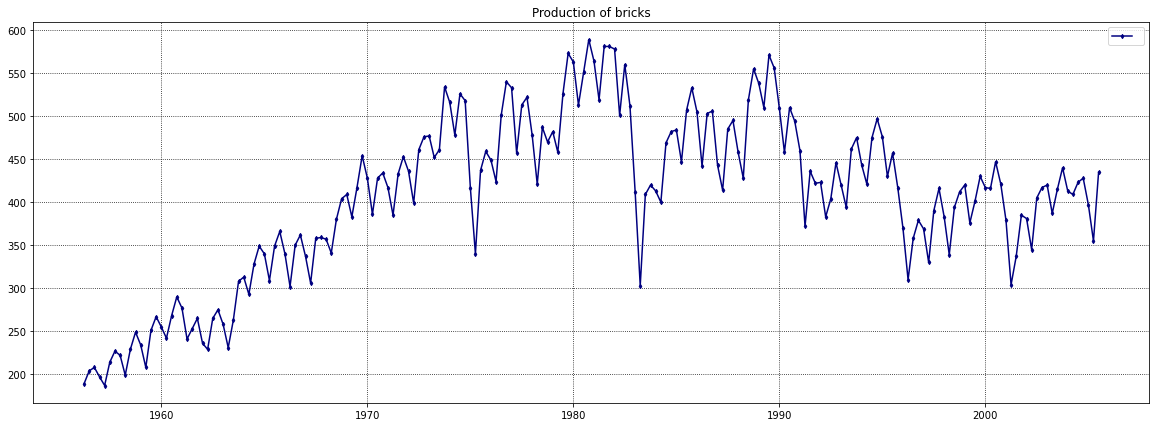

In [81]:
plotSeries(aus_production, title='Production of bricks')

# Specify

In [82]:
# I want to predict to the next 4 year
FORECAST_RANGE = 16 
train_x, train_y = get_train_x_y(aus_production, forecast_range=FORECAST_RANGE)

In [83]:
model = TSNaive(train_x)

# Estimate

In [84]:
y_pred = model.forecast(periods=FORECAST_RANGE)

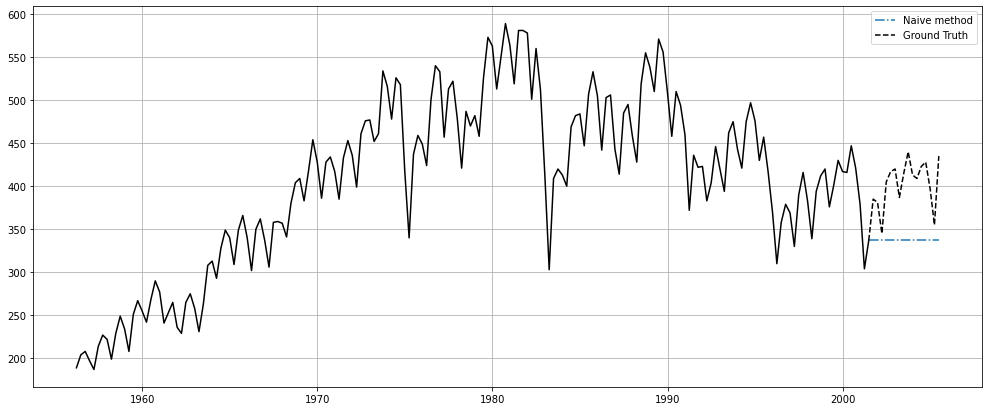

In [85]:
plt.subplots(1, 1, figsize=(17, 7))
ax = plt.subplot(1, 1, 1)

plt.plot(train_x, color='k')
plt.plot(y_pred, linestyle = '-.', color='C0', label='Naive method')
plt.plot(train_y, color='k', linestyle = '--' , label='Ground Truth')

plt.legend()
plt.grid()

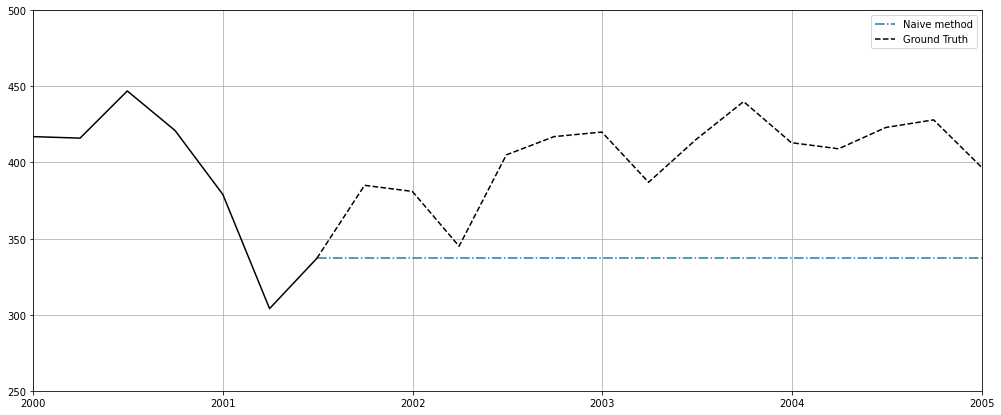

In [86]:
plt.subplots(1, 1, figsize=(17, 7))
ax = plt.subplot(1, 1, 1)

ax.set_xlim(pd.to_datetime('2000'), pd.to_datetime('2005'))
ax.set_ylim(250, 500)

plt.plot(train_x, color='k')
plt.plot(y_pred, linestyle = '-.', color='C0', label='Naive method')
plt.plot(train_y, color='k', linestyle = '--' , label='Ground Truth')

plt.legend()
plt.grid()


In [197]:
class ModelsMetrics:
    def __init__(self):
        self.all_metrics = pd.DataFrame()
        
    def get_model_metrics(self, y_true, y_pred, model_name='model_name'):
        idx = y_pred.isna()
        y_true = y_true[~idx]
        y_pred = y_pred[~idx] 
            
        mape = mean_absolute_percentage_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mse)

        model_metrics = pd.DataFrame({'MAE': [mae], 'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2]}, index=[model_name])
        self.all_metrics = pd.concat([self.all_metrics, model_metrics])
        return self.all_metrics
    
    def get_all_model_metrics(self):
        return self.all_metrics

In [198]:
metrics = ModelsMetrics()

In [199]:
metrics.get_model_metrics(train_y, y_pred, model_name='Naive')

,MAE,RMSE,MAPE,R2
Naive,62.529412,69.271418,0.151475,-4.400088


# Seasonal decompose

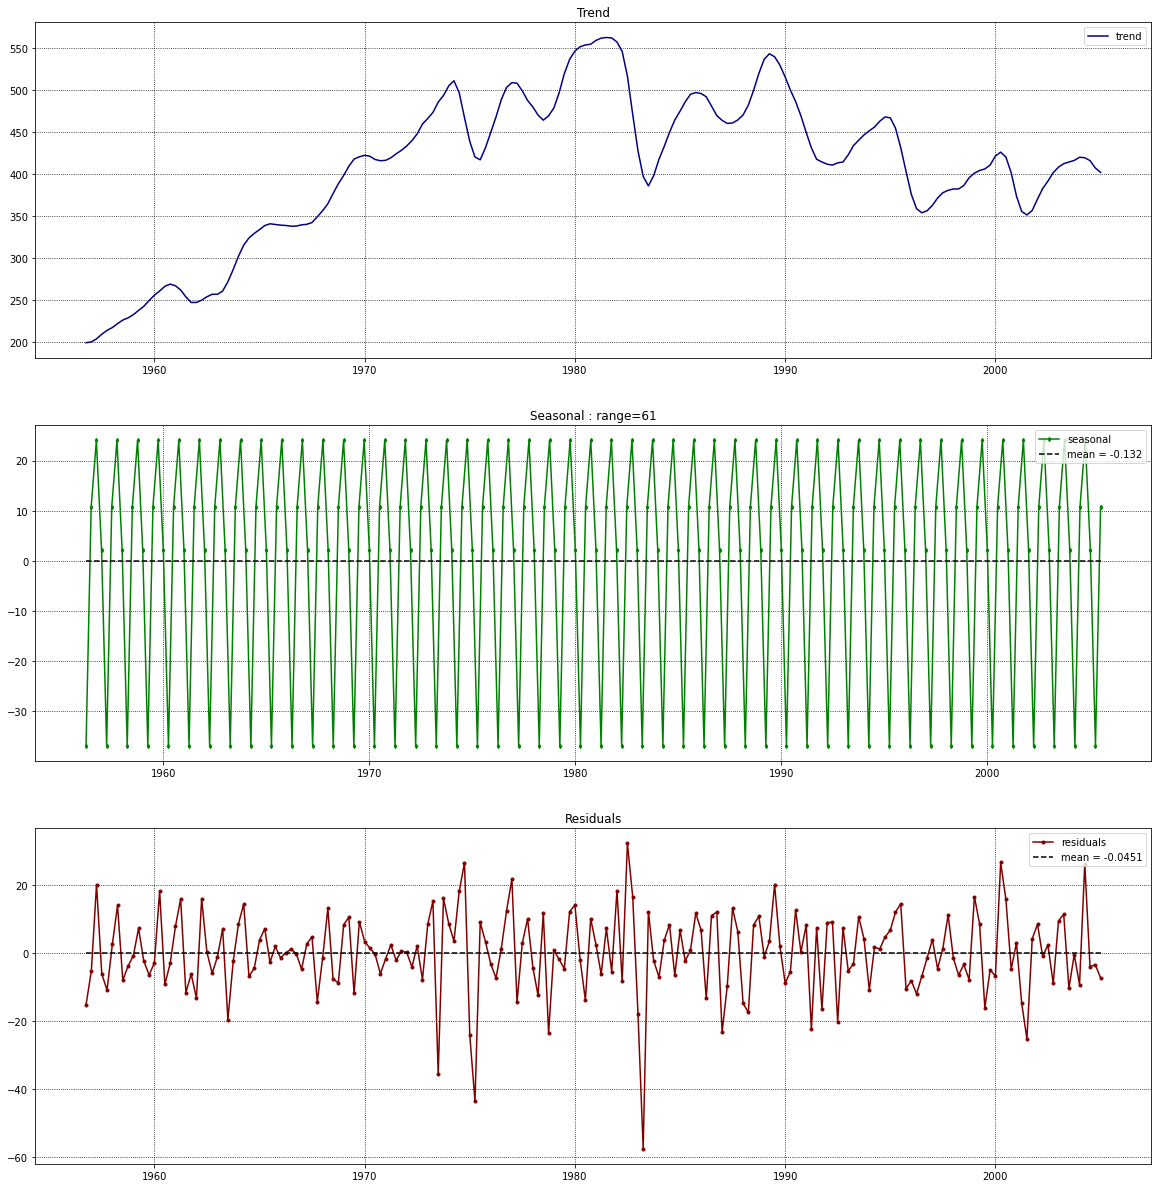

In [200]:
decompose = seasonal_decompose(aus_production, model='additive', period=4)
plot_decomposition(decompose)

In [201]:
_, seasonal_decompose_resid = get_train_x_y(decompose.resid, forecast_range=FORECAST_RANGE)

In [202]:
seasonal_decompose_resid

2001-06-30   -25.315955
2001-09-30     4.105389
2001-12-31     8.391103
2002-03-31    -1.055538
2002-06-30     2.309045
2002-09-30    -9.019611
2002-12-31     9.391103
2003-03-31    11.319462
2003-06-30   -10.440955
2003-09-30    -0.519611
2003-12-31    -9.358897
2004-03-31    26.194462
2004-06-30    -4.065955
2004-09-30    -3.519611
2004-12-31    -7.358897
2005-03-31          NaN
2005-06-30          NaN
Freq: Q-DEC, Name: resid, dtype: float64

In [203]:
metrics.get_model_metrics(train_y, train_y - seasonal_decompose_resid, model_name='seasonal decompose')

,MAE,RMSE,MAPE,R2
Naive,62.529412,69.271418,0.151475,-4.400088
seasonal decompose,8.824373,11.542328,0.022615,0.831499


# Residual analysis

In [209]:
model_resid = train_y - y_pred
model_resid

2001-06-30      0.0
2001-09-30     48.0
2001-12-31     44.0
2002-03-31      8.0
2002-06-30     68.0
2002-09-30     80.0
2002-12-31     83.0
2003-03-31     50.0
2003-06-30     78.0
2003-09-30    103.0
2003-12-31     76.0
2004-03-31     72.0
2004-06-30     86.0
2004-09-30     91.0
2004-12-31     60.0
2005-03-31     18.0
2005-06-30     98.0
Freq: Q-DEC, dtype: float64

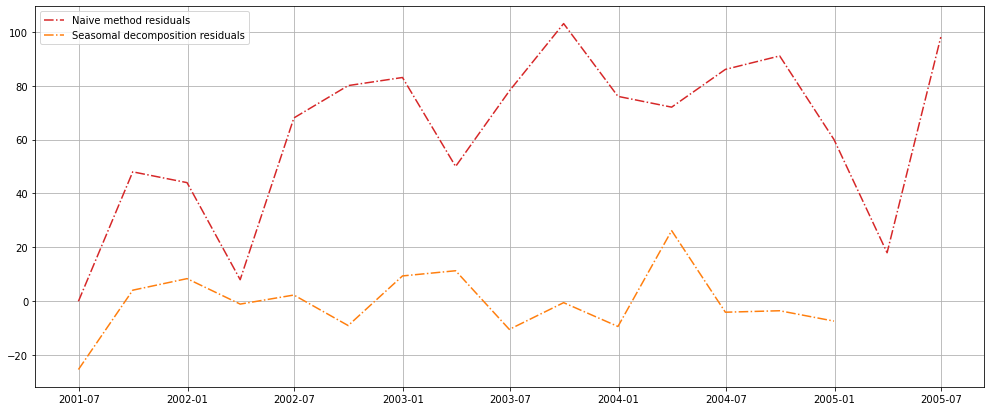

In [213]:
plt.subplots(1, 1, figsize=(17, 7))
ax = plt.subplot(1, 1, 1)

plt.plot(model_resid, linestyle = '-.', color='C3', label='Naive method residuals')
plt.plot(seasonal_decompose_resid, linestyle = '-.', color='C1', label='Seasomal decomposition residuals')

plt.legend()
plt.grid()

## Model residuals

### Intro

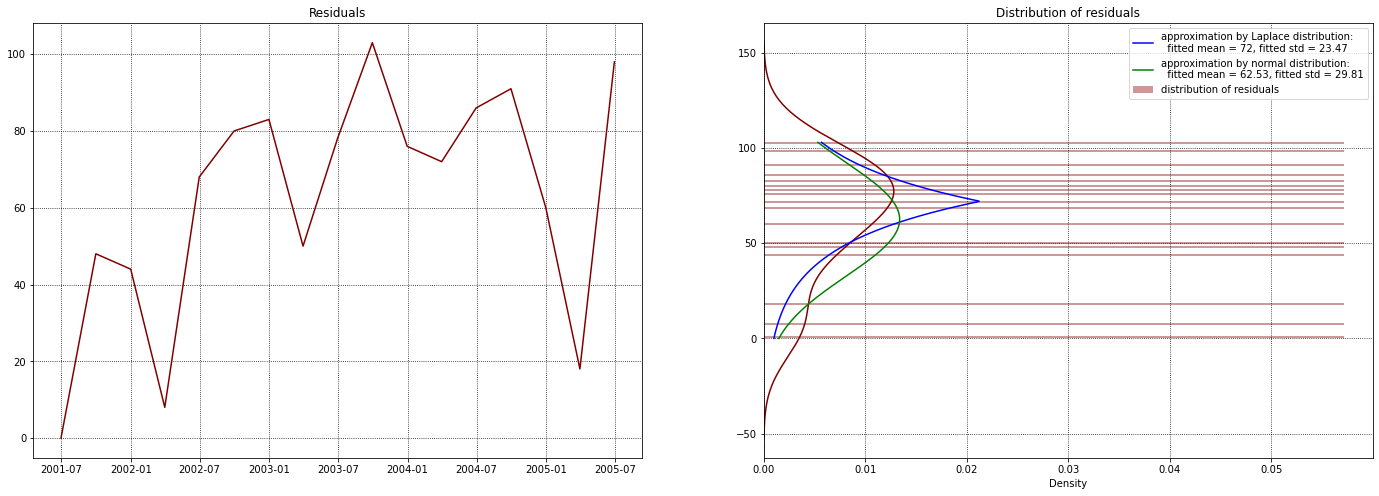

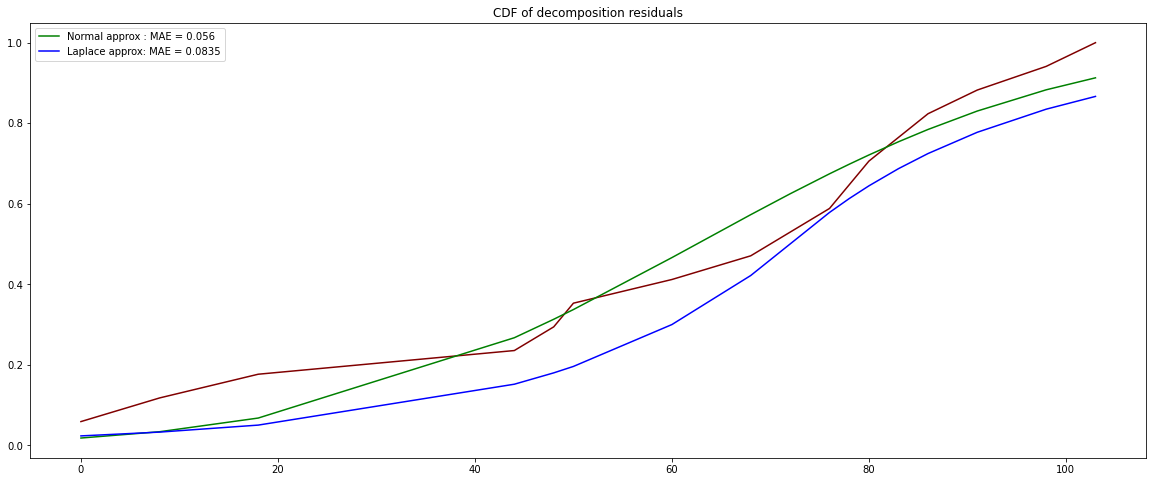

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====
ADF Statistic: -2.5407017244952175
p-value: 0.10588254300731337
The process is non-stationary by ADF.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====
KPSS Statistic = 0.30124541824188217
p-value = 0.1
The process is stationary by KPSS.



In [230]:
get_resid_analytics(model_resid)

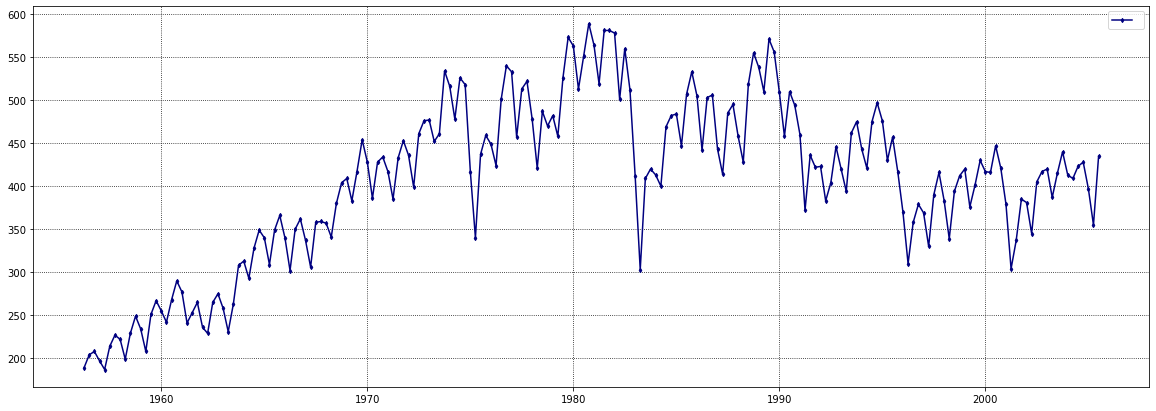

In [252]:
plot_series(aus_production)

Видно, что в остатках осталась сезонная компонента (1,2 кварталы - убыточные;  3,4 - прибыльные) + средняя ошибок сильно смещена от 0. По тестам можно сказать, что ряд нестационалный по ADF.

Дисперсия ряда != const => ряд гетероскедантичный. (По хорошему это нужно проверить) 

### Autocorrelation

In [246]:
def plot_ACF_residuals(resid, lags=10):
    resid = resid.dropna()
    fig, axes = plt.subplots(figsize=(17, 6))
    plot_acf(
        resid,
        lags=lags,
        vlines_kwargs={'color': 'maroon'},
        markerfacecolor='maroon',
        markeredgecolor='maroon',
        title='Autocorrelation of residuals', ax=axes)
    plt.show()

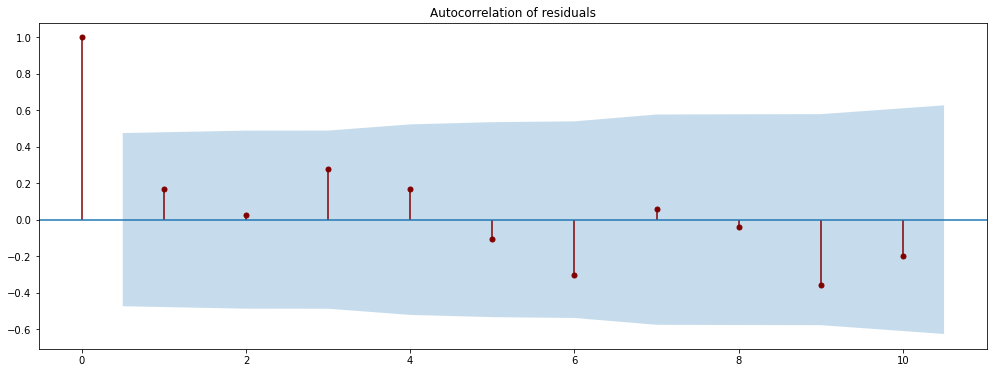

In [247]:
plot_ACF_residuals(model_resid)

Видно, что автокорреляция мала, так как все лаги лежат внутри двух синих линий (откуда берутся эти линии?). Воспользуемся тестом Дарбина-Уотсона для нахождения автокорреляции во временных рядах.

Значение статистики Дарбина-Уотсона изменяется в диапазоне от 0 до 4. При этом d = 2 указывает на отсутствие автокорреляции элементов временного ряда. Если d меньше двух, то имеет место положительная автокорреляция, а больше двух — отрицательная.



### durbin_watson

In [256]:
from statsmodels.stats.stattools import durbin_watson

In [257]:
durbin_watson(model_resid)

0.24465828991725405

Судя по тесту, в ряду присутствует положительная автокорреляция, но почему она такая большая (по acf нету значимых лагов)?

### Ljung-Box Q-test

In [258]:
from statsmodels.stats.api import acorr_ljungbox

In [261]:
sm.stats.acorr_ljungbox(model_resid, lags=[1,2,3,4,5,6,7,8,9,10], return_df=True)

,lb_stat,lb_pvalue
1,0.572174,0.449396
2,0.584417,0.746613
3,2.344448,0.504059
4,3.051783,0.549197
5,3.342739,0.647305
6,6.056101,0.416935
7,6.170043,0.520041
8,6.234604,0.620971
9,11.443767,0.246512
10,13.303844,0.207176


Мы видим, что pvalue > 0.05 => мы не можем отвергнуть нулевую гипотезу теста и сделать вывод, что значения данных независимы.

### runs test

In [262]:
from statsmodels.sandbox.stats.runs import runstest_1samp 

In [270]:
runstest_1samp(model_resid, correction=False)

(-1.676509841817112, 0.09363837008171193)

pvalue > 0.05 -> мы не может отвергнуть 0 гипотезу, то есть остатки неслучайны

### Heteroscedasticity

In [279]:
from statsmodels.stats.diagnostic import het_arch
# Авторегрессионная условная гетероскедастичность


In [278]:
het_arch(model_resid)[:2]

(9.0, 0.34229595583459105)

доразобраться...

## Seasonal decompose residuals

In [295]:
seasonal_decompose_resid = decompose.resid.dropna()

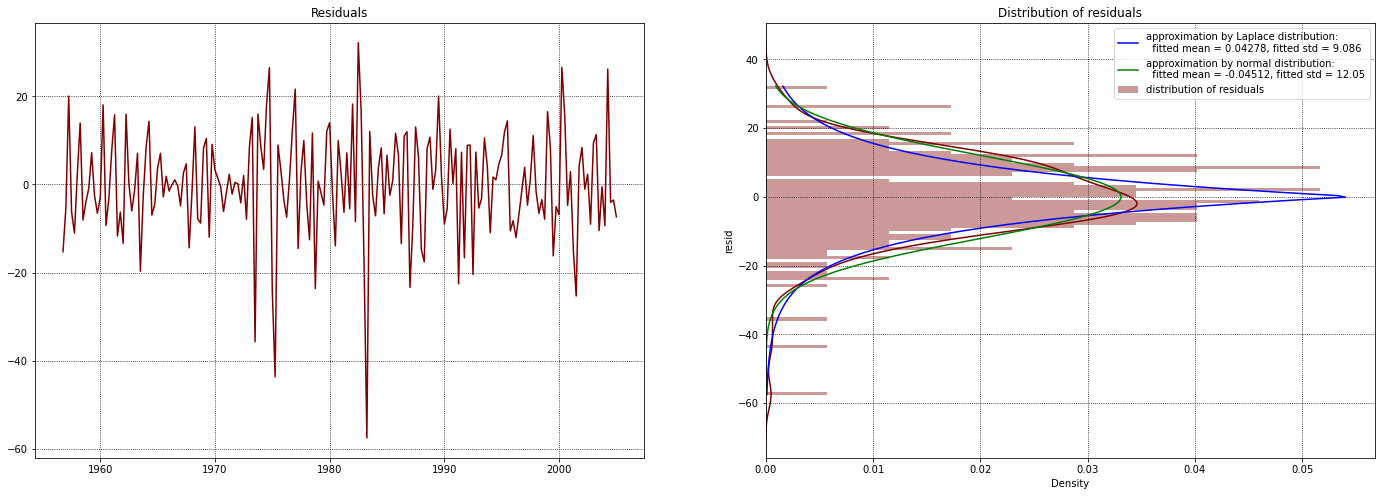

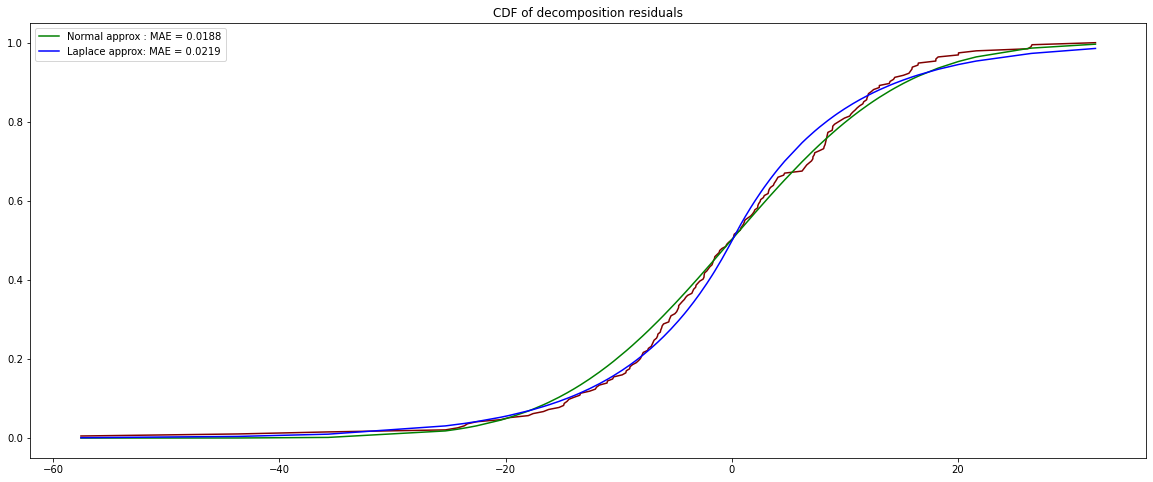

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====
ADF Statistic: -7.311213778402368
p-value: 1.262919643861356e-10
The process is stationary by ADF.

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====
KPSS Statistic = 0.05684543648089396
p-value = 0.1
The process is stationary by KPSS.



In [296]:
get_resid_analytics(seasonal_decompose_resid)

### Autocorrelation

In [297]:
def plot_ACF_residuals(resid, lags=10):
    resid = resid.dropna()
    fig, axes = plt.subplots(figsize=(17, 6))
    plot_acf(
        resid,
        lags=lags,
        vlines_kwargs={'color': 'maroon'},
        markerfacecolor='maroon',
        markeredgecolor='maroon',
        title='Autocorrelation of residuals', ax=axes)
    plt.show()

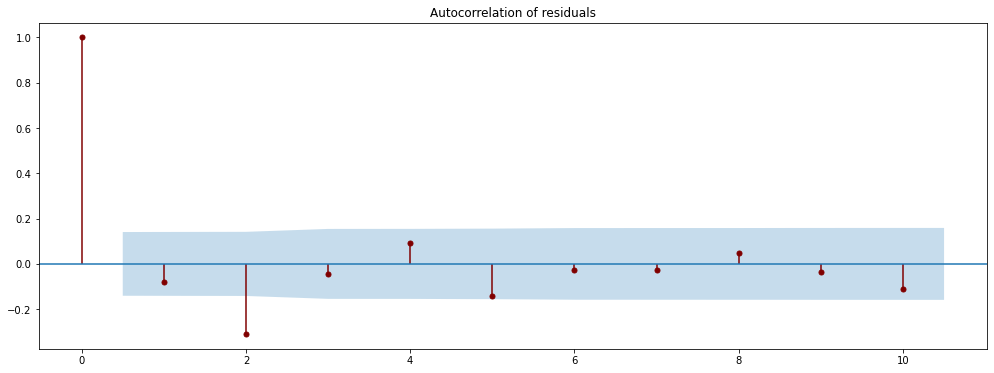

In [298]:
plot_ACF_residuals(seasonal_decompose_resid)

### durbin_watson

In [299]:
from statsmodels.stats.stattools import durbin_watson

In [300]:
durbin_watson(seasonal_decompose_resid.dropna())

2.151256417312036

ADF и KPSS показывают стационарность, что достаточно очевидно по остаткам (mean = 0, var=const). По ACF графику видно, что большинство лагов находятся в интервале (кроме 2)

Тест durbin_watson близок к 2 -> автокорреляции нет (почти нет)

### Ljung-Box Q-test

In [301]:
from statsmodels.stats.api import acorr_ljungbox

In [308]:
sm.stats.acorr_ljungbox(seasonal_decompose_resid.dropna(), lags=[2,3,4,5,6,7,8,9,10], return_df=True)

,lb_stat,lb_pvalue
2,20.256220,0.000040
3,20.620447,0.000126
4,22.376880,0.000169
5,26.321824,0.000077
6,26.457933,0.000183
7,26.600472,0.000393
8,27.046561,0.000694
9,27.302143,0.001246
10,29.776837,0.000932


Видно, что p-value < 0.05, значит мы принимаем 0 гипотезу и можем сказать, что остатки случайны

### runs test

In [309]:
from statsmodels.sandbox.stats.runs import runstest_1samp 

In [315]:
runstest_1samp(seasonal_decompose_resid)

(1.2956857436862352, 0.19508377493405582)

???

### Heteroscedasticity

In [305]:
from statsmodels.stats.diagnostic import het_arch
# Авторегрессионная условная гетероскедастичность


In [307]:
het_arch(seasonal_decompose_resid.dropna())

(14.277276289631669,
 0.5046123427179634,
 0.9418639933378254,
 0.5193984303618056)

???